In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import regex
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from string import punctuation

In [2]:
# Descarga de datos
# path = kagglehub.dataset_download("dipankarsrirag/topic-modelling-on-emails")

### Carga de datos

In [3]:
# 
path = "./data"
folders = ["Crime", "Entertainment", "Politics", "Science"]
data = []

for folder in folders:
    files = os.listdir(os.path.join(path, folder))
    for file in files:
        try:
            with open(os.path.join(path, folder,file)) as f:
                contents = " ".join(f.readlines())
                data.append([file.split(".")[0], folder, contents])
                f.close()
        except Exception as e:
            pass

df = pd.DataFrame(data, columns=['ID', 'Category', 'Content'])
df

,ID,Category,Content
0,15603,Crime,"\n Excerpts from the Clipper announcement, wit..."
1,15617,Crime,"\n In article <strnlghtC5toC6.KIu@netcom.com>,..."
2,15171,Crime,Sender: news@cujo.curtin.edu.au (News Manager)...
3,15818,Crime,\n I've been thinking about how difficult i...
4,15824,Crime,\n In article merlin@lerami.lerctr.org (David ...
...,...,...,...
9134,59410,Science,\n Colonics were a health fad of the 19th cent...
9135,59404,Science,Distribution: world\n Message-ID: <1rk9qjINN8i...
9136,53897,Science,\n Several years back one of the radar detecto...
9137,54120,Science,Message-ID: <735604750.28979.0@unix5.andrew.cm...


Distribución de categorías inicial:


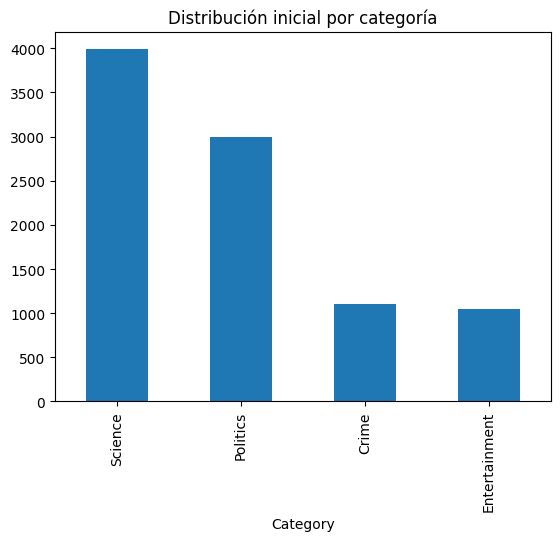

In [4]:
print("Distribución de categorías inicial:")
df["Category"].value_counts().plot.bar()
plt.title("Distribución inicial por categoría")
plt.show()

## Preprocesamiento

In [5]:
wordnet_lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words("english") + list(punctuation))
custom_stopwords = {"email", "subject", "re", "fw", "https", "www"}
stop.update(custom_stopwords)

def clean_text(text, stop_words):
    """
        Preprocesamiento:
            limpieza, 
            tokenización, 
            lematización
    """
    try:
        tokens = WordPunctTokenizer().tokenize(text.lower())
        filtered = [
            regex.sub(r'\p{^Latin}', '', w)  # Filtrar caracteres
            for w in tokens if w.isalpha() and len(w) > 3
        ]
        
        filtered = [
            wordnet_lemmatizer.lemmatize(w, pos="v") 
            for w in filtered if w not in stop_words
        ]
        return " ".join(filtered)
    except Exception as e:
        print(f"Error procesando texto: {text[:50]}... {e}")
        return ""

# Limpieza al dataset
df["FixedText"] = df["Content"].apply(lambda x: clean_text(x, stop))
df.head()

,ID,Category,Content,FixedText
0,15603,Crime,"\n Excerpts from the Clipper announcement, wit...",excerpt clipper announcement question ability ...
1,15617,Crime,"\n In article <strnlghtC5toC6.KIu@netcom.com>,...",article netcom strnlght netcom david sternligh...
2,15171,Crime,Sender: news@cujo.curtin.edu.au (News Manager)...,sender news cujo curtin news manager organizat...
3,15818,Crime,\n I've been thinking about how difficult i...,think difficult would make available form ebcd...
4,15824,Crime,\n In article merlin@lerami.lerctr.org (David ...,article merlin lerami lerctr david hay write a...


### Verctorizar

In [6]:
# Convertir texto en representaciones numéricas (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000, lowercase=False)
X = tfidf.fit_transform(df["FixedText"])
y = df["Category"]

print(f"Dimensiones del dataset vectorizado: {X.shape}")

Dimensiones del dataset vectorizado: (9139, 5000)


### Sampling y undersampling

Distribución después del balanceo:
Counter({'Politics': 2500, 'Science': 2500, 'Crime': 2000, 'Entertainment': 2000})


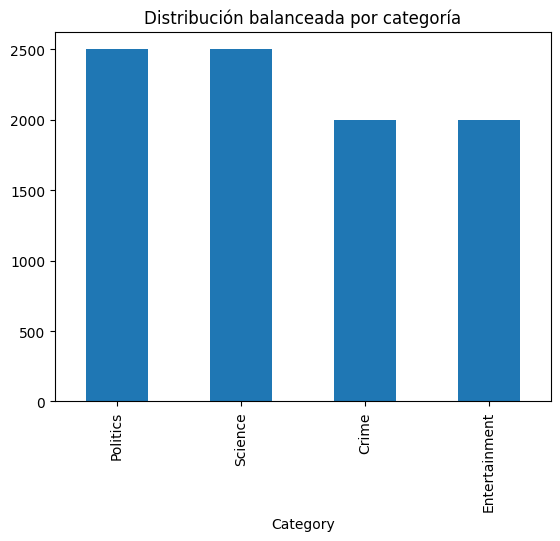

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# Estrategia de balanceo
sampling_strategy = {
    "Science": 2500,       # Reducir
    "Politics": 2500,      # Reducir
    "Crime": 2000,         # Aumentar
    "Entertainment": 2000  # Aumentar
}

# Balanceo personalizado (SMOTE + Submuestreo manual)
smote = SMOTE(
    sampling_strategy=
        {k: v for k, v in sampling_strategy.items() if v > Counter(y)[k]}
    , random_state=42
)

X_smote, y_smote = smote.fit_resample(X, y)

undersample = RandomUnderSampler(
    sampling_strategy=
    {k: v for k, v in sampling_strategy.items() if v < Counter(y_smote)[k]}
    , random_state=42
)

X_resampled, y_resampled = undersample.fit_resample(X_smote, y_smote)

# Reconstruir DataFrame balanceado
balanced_df = pd.DataFrame.sparse.from_spmatrix(
    X_resampled, 
    columns=tfidf.get_feature_names_out()
)
balanced_df["Category"] = y_resampled

# Balance final
print("Distribución después del balanceo:")
balanced_distribution = Counter(y_resampled)
print(balanced_distribution)

balanced_df["Category"].value_counts().plot.bar()
plt.title("Distribución balanceada por categoría")
plt.show()

In [8]:
balanced_df

,aaron,abandon,abide,ability,able,abolish,abort,abortion,abortions,abroad,...,zealand,zero,zeus,zinaida,zionism,zionist,zionists,zone,zoology,Category
0,0,0,0,0.050458,0,0,0,0,0,0.131903,...,0,0,0,0,0,0,0,0,0,Crime
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Crime
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Crime
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Crime
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Crime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Science
8996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Science
8997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Science
8998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Science
